In [1]:
#https://towardsdatascience.com/auto-generated-knowledge-graphs-92ca99a81121

In [2]:
import pandas as pd
import re
import spacy
import os.path
my_path = os.path.abspath('')

nlp = spacy.load('en_core_web_lg')
def preprocessing(text):
    text = re.sub(r'\n\W\n', '\n\n', text)  # remove non-alphanumeric
    text = re.sub(r'\n\d+\n', '\n\n', text)  # remove just number line
    text = re.sub(r'\t+', ' ', text)  # replace tab with space
    text = re.sub(r'\n+', '\n', text)  # remove multiple newlines
    # merge splited sentence
    text = re.sub(r'\n\.', '.', text)  
    text = re.sub(r'\n,', ',', text)
    text = re.sub(r'\n ', ' ', text)
    text = re.sub(r' \n ', ' ', text)
    
    return text
def entity_pairs(text):
    text = preprocessing(text)
    text = nlp(text)

    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))==1 and (dep.count('subj')+dep.count('nsubj'))==1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                            # add adposition or particle to relationship
                            if relation.nbor(1).pos_ in ('ADP', 'PART'):  
                                relation = ' '.join((str(relation),
                                        str(relation.nbor(1))))
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    print('Entity pairs extracted:', str(len(filtered_ent_pairs)))
    return pairs


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)
    elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
        t = ''
        for i in range(len(sent) - ent.i):
            if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                t += ' ' + str(ent.nbor(i))
            else:
                ent = t.strip()
                break
    return ent, ent_type



In [3]:
def file_reader(path):
    files = []
    for r,d,f in os.walk(path):
        for file in f:
            if '.txt' in file:
                files.append(os.path.join(r,file))
                
    return files

#print elements from list
def print_list(lists):
    for list in lists:
        print(list)

In [15]:

files = file_reader(my_path+"/clean_data/filing_13")
files.sort()
print_list(files)

/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_0.txt
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_1.txt
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_10.txt
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_11.txt
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_12.txt
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_13.txt
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_14.txt
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_15.txt
/U

In [16]:
pairs = pd.DataFrame(columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])

for i in range(len(files)):
    #print(file)
    print(files[i])
    print(str(i))
    if i==34 or i == 275 or i==547 or i==564 or i==608:
        i=i+1
        print(str(i))
    text=open(files[i])
    i=i+1
    pairs=pairs.append(entity_pairs(text.read()),ignore_index=True)
    print(pairs.shape)

"""



    
text=open(files[0])
pairs = pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)
text=open(files[1])
pairs = pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)
text=open(files[3])
pairs = pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)
text=open(files[4])
pairs = pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)
text=open(files[5])
pairs = pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)
text=open(files[6])
pairs = pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)
text=open(files[7])
pairs = pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)
text=open(files[8])
pairs = pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)
"""


    
#filing_1_section_17.txt, filing_2_section_17.txt, filing_4_section_17.txt, filing_5_section_10.txt, filing_7_section_10.txt



# error message [E042] Error accessing doc[7].nbor(1), for doc of length 8

/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_0.txt
0
Entity pairs extracted: 86
(86, 5)
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_1.txt
1
Entity pairs extracted: 33
(119, 5)
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_10.txt
2
Entity pairs extracted: 0
(119, 5)
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_11.txt
3
Entity pairs extracted: 1
(120, 5)
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_12.txt
4
Entity pairs extracted: 4
(124, 5)
/Users/davidren/Desktop/Education/KTH/2019-2020/2020 Spring/Master Thesis/Data/clean_data/filing_13/filing_13_section_13.txt
5
Entity pairs extracted: 1
(125, 5)
/Users/davidren/Desktop/Educa

'\n\n\n\n    \ntext=open(files[0])\npairs = pairs.append(entity_pairs(text.read()),ignore_index=True)\nprint(pairs.shape)\ntext=open(files[1])\npairs = pairs.append(entity_pairs(text.read()),ignore_index=True)\nprint(pairs.shape)\ntext=open(files[3])\npairs = pairs.append(entity_pairs(text.read()),ignore_index=True)\nprint(pairs.shape)\ntext=open(files[4])\npairs = pairs.append(entity_pairs(text.read()),ignore_index=True)\nprint(pairs.shape)\ntext=open(files[5])\npairs = pairs.append(entity_pairs(text.read()),ignore_index=True)\nprint(pairs.shape)\ntext=open(files[6])\npairs = pairs.append(entity_pairs(text.read()),ignore_index=True)\nprint(pairs.shape)\ntext=open(files[7])\npairs = pairs.append(entity_pairs(text.read()),ignore_index=True)\nprint(pairs.shape)\ntext=open(files[8])\npairs = pairs.append(entity_pairs(text.read()),ignore_index=True)\nprint(pairs.shape)\n'

In [17]:
print(pairs)

                                      subject            relation  \
0                                     context                  is   
1                                   BlackRock              offers   
2                                   BlackRock              serves   
3                                     Clients             include   
4                                   BlackRock       commitment to   
5                                     Company                made   
6                                  Percentage          represents   
7                                  Percentage          represents   
8                                     Amounts             include   
9                                  Percentage          represents   
10                                  BlackRock              offers   
11                                        mix         encompasses   
12                                  BlackRock              serves   
13                                

In [18]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()
    


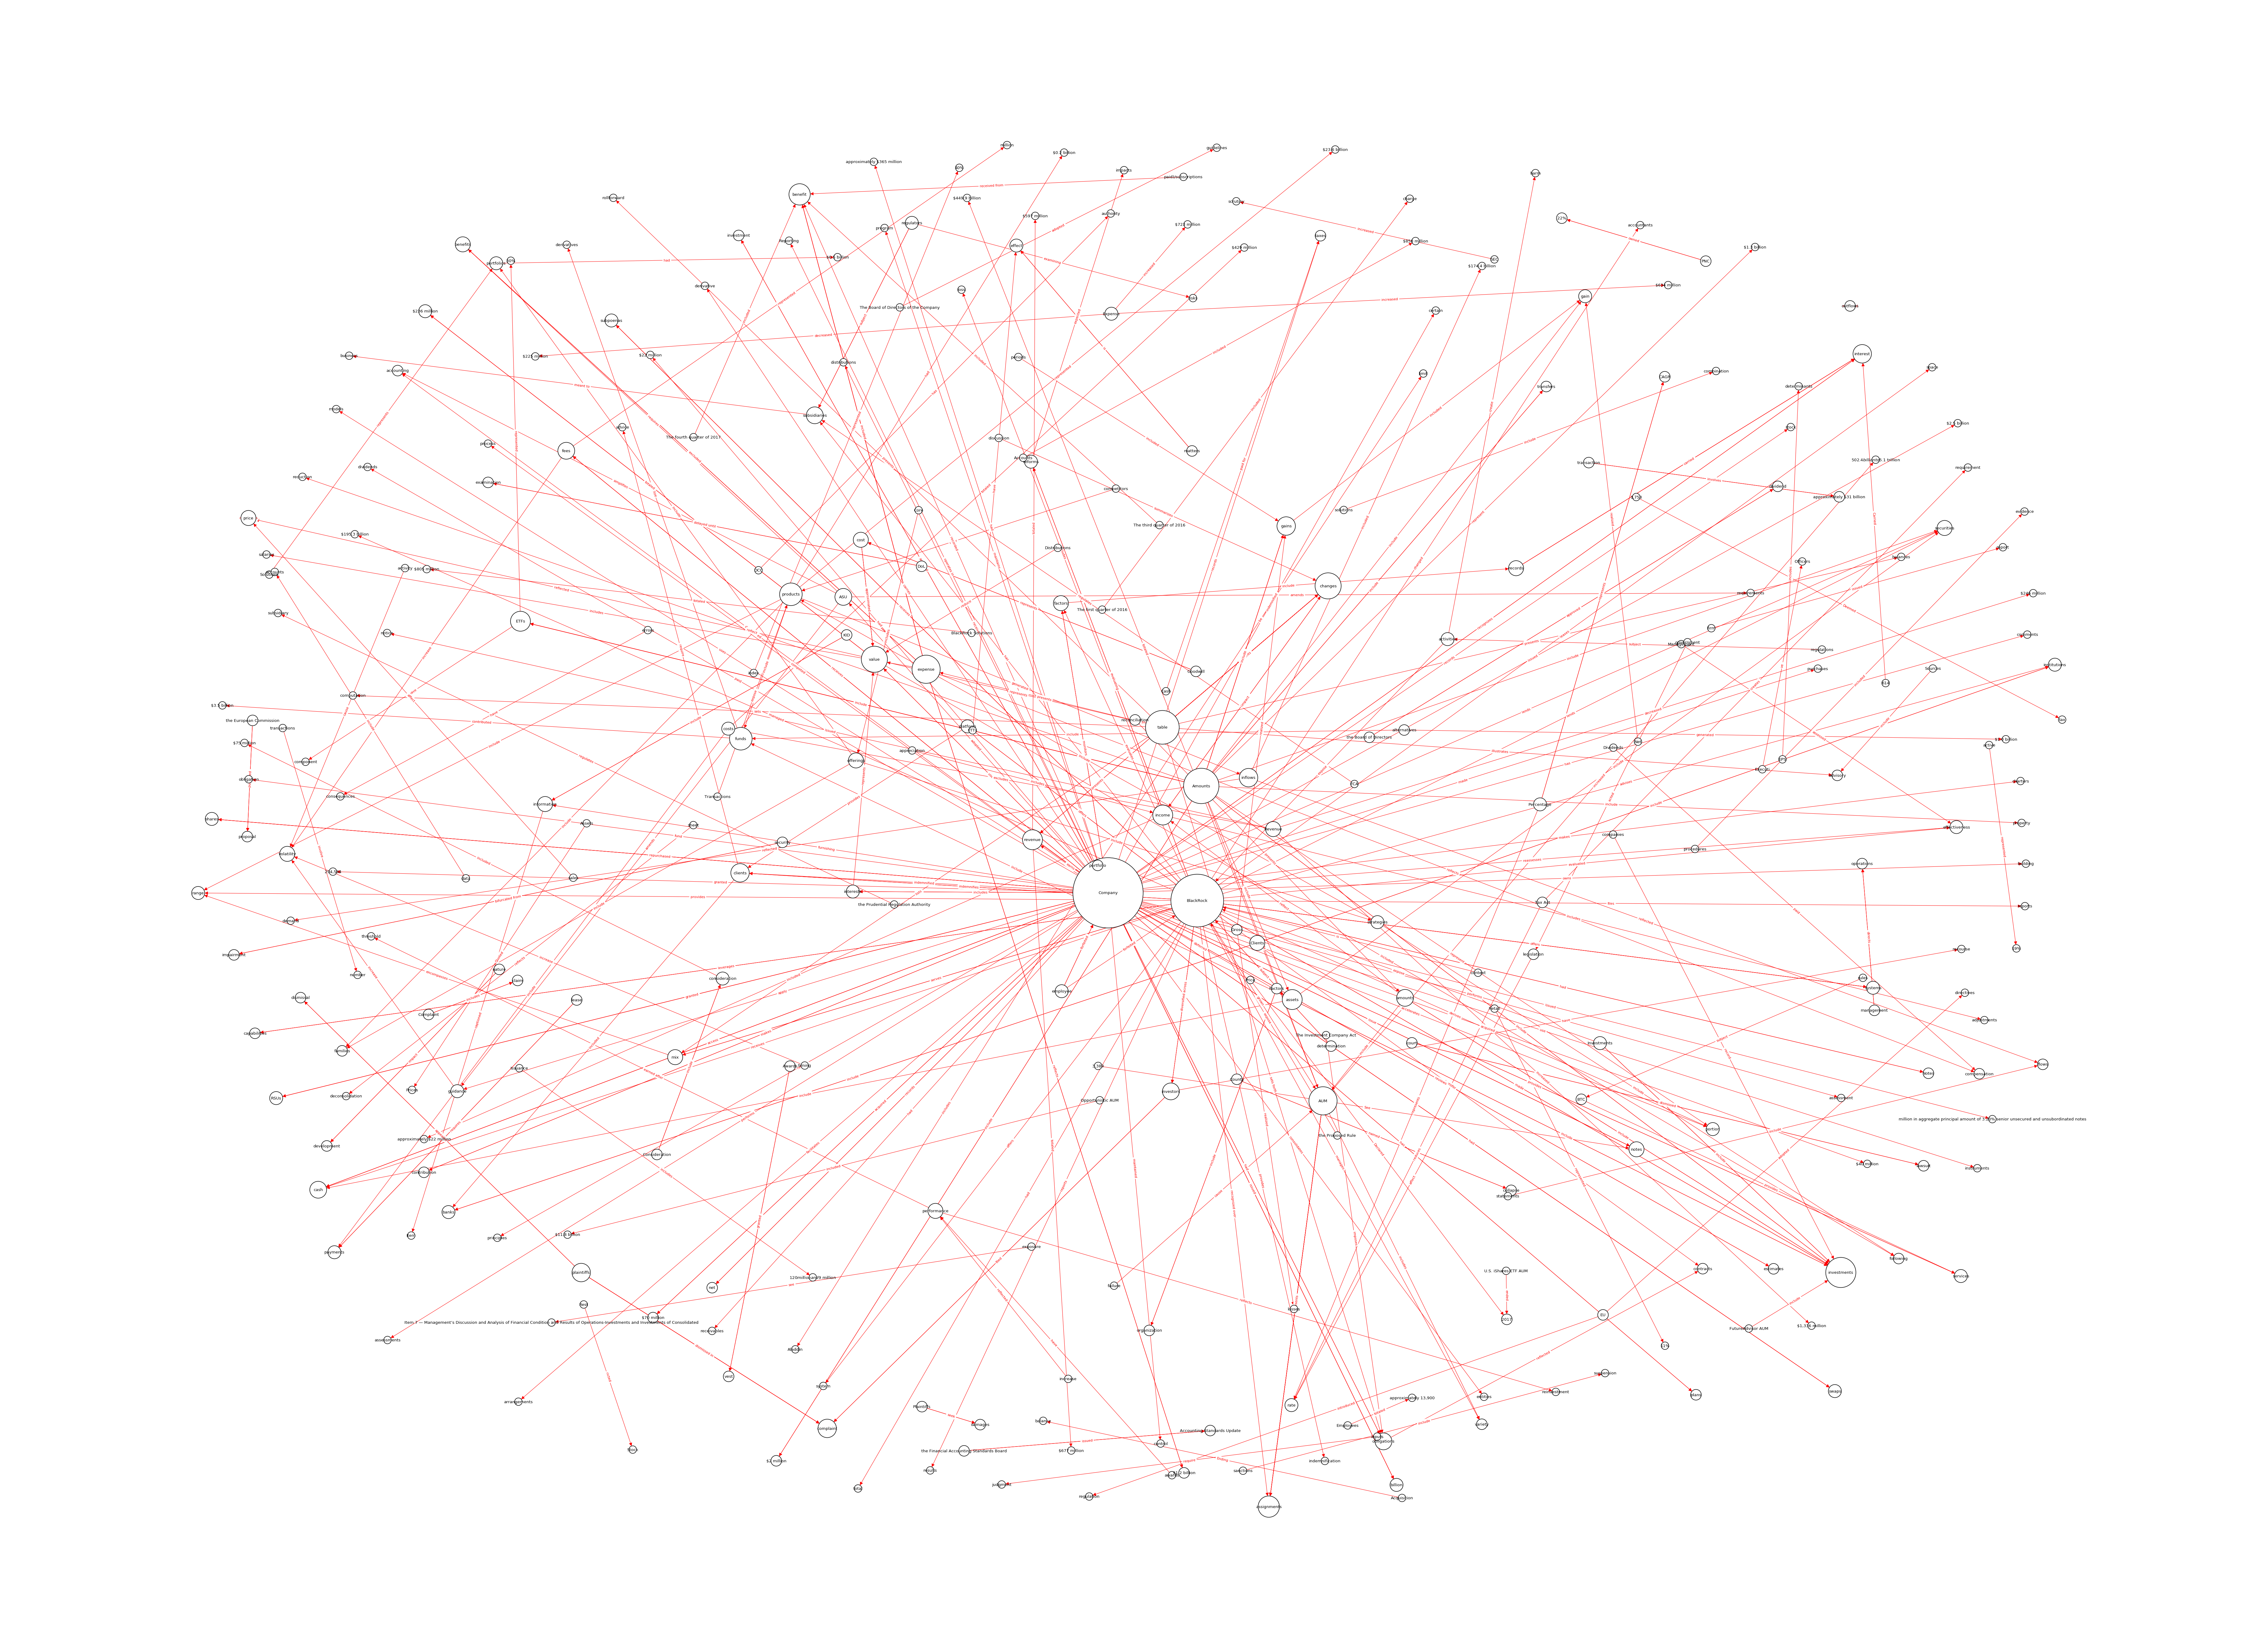

In [19]:
draw_kg(pairs)

In [ ]:
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    #print(k_graph.out_edges(data=False))
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

In [ ]:
filter_graph(pairs,'AC+')

In [7]:
pairs = pd.DataFrame(columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
text=open(files[1])
pairs=pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)

Entity pairs extracted: 4
(4, 5)


In [9]:
text=open(files[3])
pairs=pairs.append(entity_pairs(text.read()),ignore_index=True)
print(pairs.shape)

Entity pairs extracted: 69
(74, 5)
